1. Read in the train and test files
2. Drop and encode the columns as needed
3. Use the XgBoost Model 
4. Use grid search along with Cross validation to find the best parameters.
5. Check feature importance and do one round of re-training if there are features which are not important.
6. Save the holdout dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_columns = None

In [2]:
df=pd.read_csv('train_dataset.csv')
holdout_df=pd.read_csv('test_dataset.csv')
df=df.drop(['area_harvested_obs','adm1_code'],axis=1)
holdout_df=holdout_df.drop(['adm1_code'],axis=1)

# Ordinal encoding of categorical column

In [3]:
encoder = OrdinalEncoder()
df['adm2_code']=encoder.fit_transform(df['adm2_code'].values.reshape(-1, 1))

In [4]:
holdout_df['adm2_code']=encoder.transform(holdout_df['adm2_code'].values.reshape(-1, 1))

In [5]:
X=df.loc[:,df.columns != 'yield_x']
y=df['yield_x']

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Data Checks

In [7]:
df.head()

,adm2_code,year,yield_x,phen_gup,phen_dor,met_extreme_cold_sum,met_extreme_hot1_sum,met_extreme_hot2_sum,met_avg_t_mean,met_min_t_min,met_max_t_max,met_max_vpd_max,met_min_rh_min,met_p_mm_mean,met_p_mm_min,met_p_mm_max,met_sh_mean,met_sh_min,met_sh_max,met_sr_wm2_mean,met_sr_wm2_min,met_sr_wm2_max,mod_evi_mean,mod_evi_min,mod_evi_max,mod_lst_day_mean,mod_lst_day_min,mod_lst_day_max,mod_lst_night_mean,mod_lst_night_min,mod_lst_night_max,mod_ndvi_mean,mod_ndvi_min,mod_ndvi_max,mod_nbar_1_mean,mod_nbar_1_min,mod_nbar_1_max,mod_nbar_2_mean,mod_nbar_2_min,mod_nbar_2_max,mod_nbar_3_mean,mod_nbar_3_min,mod_nbar_3_max,mod_nbar_4_mean,mod_nbar_4_min,mod_nbar_4_max,mod_nbar_5_mean,mod_nbar_5_min,mod_nbar_5_max,mod_nbar_6_mean,mod_nbar_6_min,mod_nbar_6_max,mod_nbar_7_mean,mod_nbar_7_min,mod_nbar_7_max
0,0.0,2003,123.0,72,295,1,0,105,295.990841,271.09167,306.39297,1.090953,28.643530,5.203809,0,57.50232,0.013721,0.01,0.017760,242.395990,71.090290,348.51974,0.412611,0.272788,0.545818,302.787696,295.92194,305.77127,289.545392,278.70140,294.55115,0.582226,0.453069,0.728950,0.093110,0.059890,0.126180,0.354316,0.257840,0.42572,0.043805,0.02819,0.058830,0.091597,0.070470,0.113350,0.383032,0.305170,0.445920,0.294719,0.242370,0.359690,0.167882,0.11175,0.234810
1,0.0,2004,111.0,72,295,2,3,112,295.946635,271.08118,309.43997,1.110776,21.180536,4.480146,0,104.05985,0.013539,0.01,0.018877,243.559584,66.946106,367.62192,0.403529,0.259658,0.563890,304.074910,296.48587,309.44354,289.178745,277.92587,294.20822,0.567168,0.394642,0.746574,0.096216,0.058518,0.139106,0.350952,0.276335,0.41190,0.045899,0.02927,0.065718,0.092265,0.069124,0.116018,0.381888,0.327212,0.419012,0.305693,0.244594,0.372859,0.178722,0.11848,0.258459
2,0.0,2005,127.0,72,295,0,1,129,296.225029,273.46927,308.15160,1.236585,26.368740,5.131178,0,75.10388,0.013804,0.01,0.019730,242.329972,94.832140,352.95486,0.416437,0.261648,0.608647,302.842733,297.16140,308.98978,289.786157,278.01443,295.17400,0.585358,0.420422,0.785504,0.092361,0.050040,0.134970,0.355018,0.270680,0.42922,0.043461,0.02456,0.062390,0.090145,0.066140,0.119400,0.380605,0.331210,0.424350,0.293601,0.237850,0.360430,0.166506,0.09699,0.249910
3,0.0,2006,85.0,72,295,2,37,153,296.704838,271.87802,310.49430,1.557903,18.919410,2.800742,0,57.60162,0.013050,0.01,0.018020,250.630870,56.840690,372.52057,0.384123,0.270349,0.556886,306.561295,295.78354,315.26825,289.104380,276.70470,293.82470,0.535076,0.410391,0.724180,0.107283,0.065160,0.150740,0.354115,0.270320,0.41658,0.051223,0.03198,0.071440,0.099908,0.074090,0.127720,0.386895,0.325580,0.432360,0.314021,0.252522,0.376950,0.202066,0.12675,0.267500
4,0.0,2007,73.0,72,295,2,29,149,296.968060,271.69128,311.83730,1.833030,20.241500,3.307996,0,65.38271,0.013127,0.01,0.018260,252.526246,90.119850,355.63074,0.388797,0.266843,0.562937,305.469293,296.88373,311.21317,289.407042,279.29303,295.98280,0.553988,0.409932,0.725044,0.099620,0.067000,0.141510,0.347252,0.283840,0.42298,0.046678,0.03336,0.065020,0.093294,0.072160,0.117330,0.383400,0.333340,0.436530,0.306551,0.256090,0.379590,0.186277,0.13142,0.266640


In [8]:
holdout_df.head()

,adm2_code,year,phen_gup,phen_dor,met_extreme_cold_sum,met_extreme_hot1_sum,met_extreme_hot2_sum,met_avg_t_mean,met_min_t_min,met_max_t_max,met_max_vpd_max,met_min_rh_min,met_p_mm_mean,met_p_mm_min,met_p_mm_max,met_sh_mean,met_sh_min,met_sh_max,met_sr_wm2_mean,met_sr_wm2_min,met_sr_wm2_max,mod_evi_mean,mod_evi_min,mod_evi_max,mod_lst_day_mean,mod_lst_day_min,mod_lst_day_max,mod_lst_night_mean,mod_lst_night_min,mod_lst_night_max,mod_ndvi_mean,mod_ndvi_min,mod_ndvi_max,mod_nbar_1_mean,mod_nbar_1_min,mod_nbar_1_max,mod_nbar_2_mean,mod_nbar_2_min,mod_nbar_2_max,mod_nbar_3_mean,mod_nbar_3_min,mod_nbar_3_max,mod_nbar_4_mean,mod_nbar_4_min,mod_nbar_4_max,mod_nbar_5_mean,mod_nbar_5_min,mod_nbar_5_max,mod_nbar_6_mean,mod_nbar_6_min,mod_nbar_6_max,mod_nbar_7_mean,mod_nbar_7_min,mod_nbar_7_max,yield_x
0,0.0,2018,72,295,1,15,101,296.390296,271.92712,309.60855,1.850344,21.85247,4.605697,0,66.77693,0.014726,0.01,0.02036,232.088161,121.01926,320.40570,0.432055,0.319842,0.553096,303.147200,292.45853,311.96457,289.824440,275.64096,295.79825,0.622351,0.466994,0.772578,0.081031,0.04743,0.11946,0.348278,0.284955,0.40321,0.038005,0.02250,0.05479,0.080275,0.05779,0.10163,0.373919,0.33051,0.41579,0.279501,0.20425,0.33791,0.153905,0.08980,0.22503,NaN
1,1.0,2018,84,281,1,5,96,296.044677,272.49080,309.48737,1.427494,26.24668,4.345303,0,69.55809,0.014111,0.01,0.02178,222.682853,86.91653,319.87323,0.419951,0.283079,0.619445,304.263345,290.87490,309.40744,288.873760,272.82584,294.34430,0.604652,0.460054,0.789561,0.083197,0.05034,0.12014,0.342237,0.250280,0.43324,0.039684,0.02641,0.05573,0.077826,0.05942,0.10092,0.368405,0.30636,0.41485,0.289563,0.26243,0.34504,0.162581,0.11447,0.22899,NaN
2,2.0,2018,73,299,5,0,59,293.815986,271.10242,307.08472,0.964378,24.12053,3.607931,0,66.27134,0.014275,0.01,0.02272,218.628756,85.60484,323.93365,0.478719,0.350967,0.683397,301.517910,289.83295,307.85180,286.874562,275.83148,292.27817,0.679734,0.564098,0.848894,0.065259,0.03728,0.09106,0.352741,0.263820,0.45627,0.033026,0.01964,0.04575,0.071812,0.05566,0.09232,0.369177,0.30906,0.41435,0.264976,0.23305,0.31855,0.131077,0.09494,0.18014,NaN
3,3.0,2018,77,292,6,0,76,294.403428,271.55865,307.52740,1.004622,27.48566,3.793989,0,68.63216,0.014345,0.01,0.02260,217.383146,72.24636,322.35490,0.471698,0.311000,0.653923,300.989931,290.46332,306.12283,288.229322,277.06677,294.12067,0.684127,0.537517,0.838969,0.062264,0.03629,0.09094,0.342776,0.241690,0.43483,0.031235,0.01872,0.04506,0.068994,0.05253,0.09117,0.355567,0.29083,0.39741,0.251313,0.21955,0.30316,0.123725,0.08602,0.17511,NaN
4,4.0,2018,78,284,2,5,98,295.413464,271.97070,309.58722,1.343378,24.64226,4.416082,0,100.49642,0.013864,0.01,0.02170,220.273567,81.11335,317.28265,0.445068,0.278448,0.663293,302.842735,291.81570,308.09473,288.325803,272.53177,295.52988,0.628486,0.470203,0.816882,0.079123,0.04607,0.11322,0.354858,0.260780,0.45998,0.037447,0.02286,0.05199,0.077360,0.05723,0.09964,0.385538,0.31610,0.43548,0.293472,0.25198,0.34857,0.158152,0.10870,0.22334,NaN


In [9]:
df.columns

Index(['adm2_code', 'year', 'yield_x', 'phen_gup', 'phen_dor',
       'met_extreme_cold_sum', 'met_extreme_hot1_sum', 'met_extreme_hot2_sum',
       'met_avg_t_mean', 'met_min_t_min', 'met_max_t_max', 'met_max_vpd_max',
       'met_min_rh_min', 'met_p_mm_mean', 'met_p_mm_min', 'met_p_mm_max',
       'met_sh_mean', 'met_sh_min', 'met_sh_max', 'met_sr_wm2_mean',
       'met_sr_wm2_min', 'met_sr_wm2_max', 'mod_evi_mean', 'mod_evi_min',
       'mod_evi_max', 'mod_lst_day_mean', 'mod_lst_day_min', 'mod_lst_day_max',
       'mod_lst_night_mean', 'mod_lst_night_min', 'mod_lst_night_max',
       'mod_ndvi_mean', 'mod_ndvi_min', 'mod_ndvi_max', 'mod_nbar_1_mean',
       'mod_nbar_1_min', 'mod_nbar_1_max', 'mod_nbar_2_mean', 'mod_nbar_2_min',
       'mod_nbar_2_max', 'mod_nbar_3_mean', 'mod_nbar_3_min', 'mod_nbar_3_max',
       'mod_nbar_4_mean', 'mod_nbar_4_min', 'mod_nbar_4_max',
       'mod_nbar_5_mean', 'mod_nbar_5_min', 'mod_nbar_5_max',
       'mod_nbar_6_mean', 'mod_nbar_6_min', 'mod_nbar

# Grid search on only two params


In [10]:
grid_param = {
    'n_estimators': [100, 500, 700, 1000, 1500],
    'max_depth': [5,7,9]
}

In [11]:
xgb_model_gs = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=100,max_depth=5)
gd_sr = GridSearchCV(estimator=xgb_model_gs,
                     param_grid=grid_param,
                     scoring='neg_mean_squared_error',
                     cv=5,
                     n_jobs=-1)

In [12]:
gd_sr.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9],
                         'n_estimators': [100, 500, 700, 1000, 1500]},
        

In [13]:
print(gd_sr.best_params_)

{'max_depth': 7, 'n_estimators': 1500}


In [16]:
print(np.sqrt(-gd_sr.best_score_))

12.93051099986458


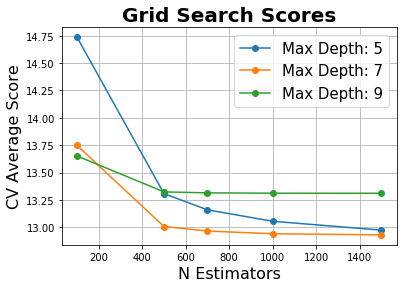

In [17]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(np.sqrt(-scores_mean)).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param 1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(gd_sr.cv_results_, grid_param['n_estimators'], grid_param['max_depth'], 'N Estimators', 'Max Depth')


In [18]:
y_pred_test=gd_sr.best_estimator_.predict(X_test)

In [20]:
mse=mean_squared_error(Y_test, y_pred_test)
print(np.sqrt(mse))

12.617863903322624


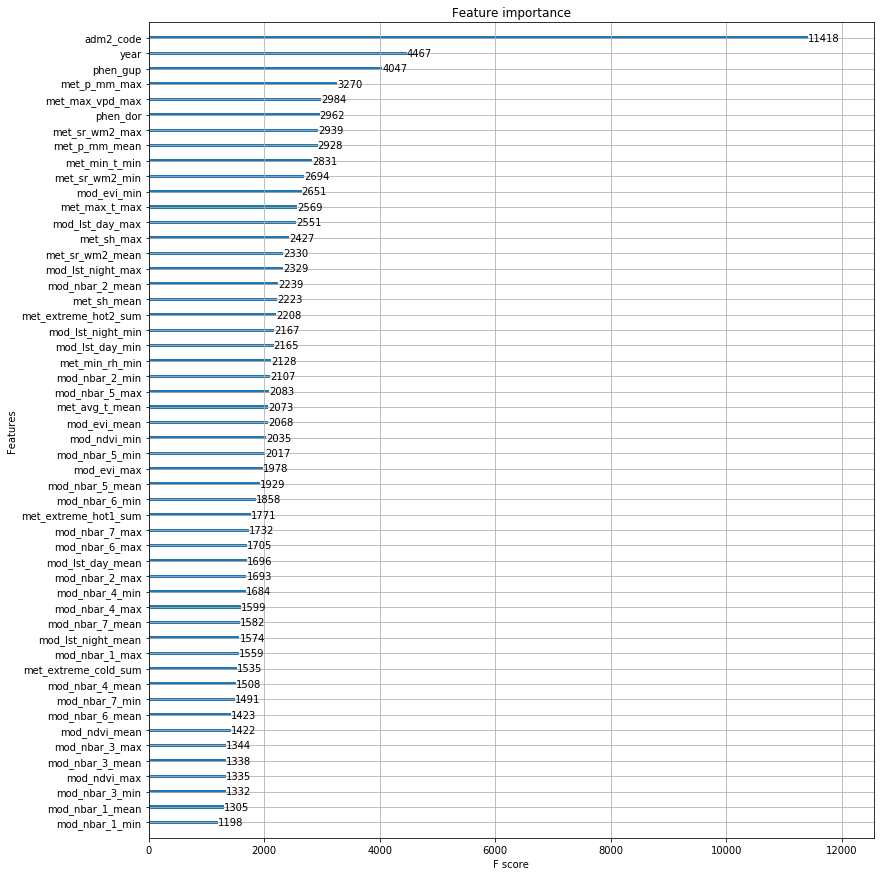

In [21]:
plt.rcParams["figure.figsize"] = (13, 15)
xgb.plot_importance(gd_sr.best_estimator_)

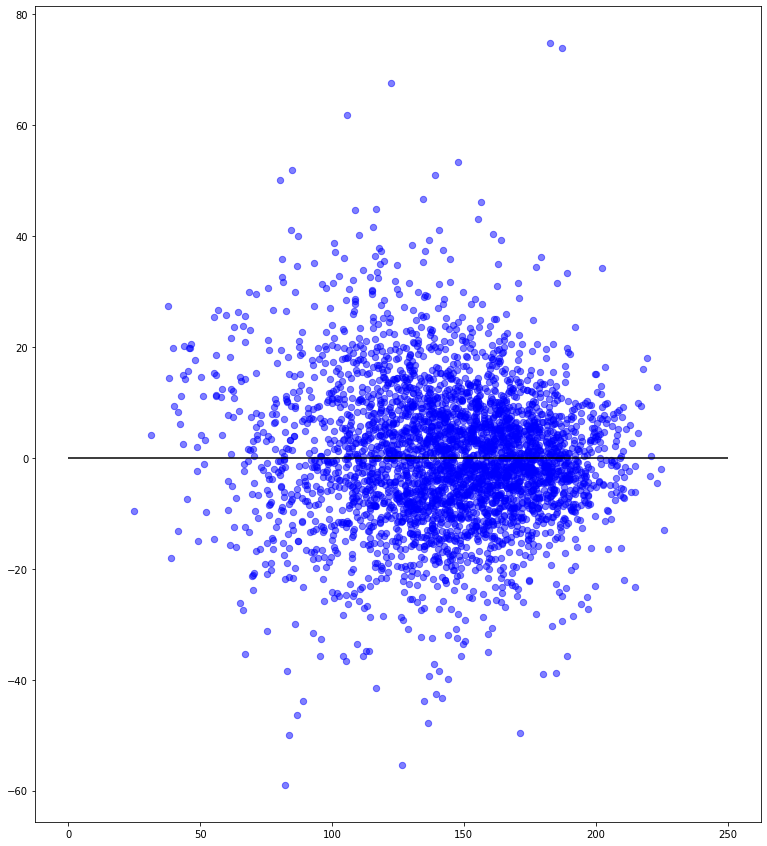

In [25]:
plt.scatter(gd_sr.best_estimator_.predict(X_test), gd_sr.best_estimator_.predict(X_test)-Y_test,c='b',s=40, alpha=0.5)
plt.hlines(y=0,xmin=0,xmax=250)
plt.show()

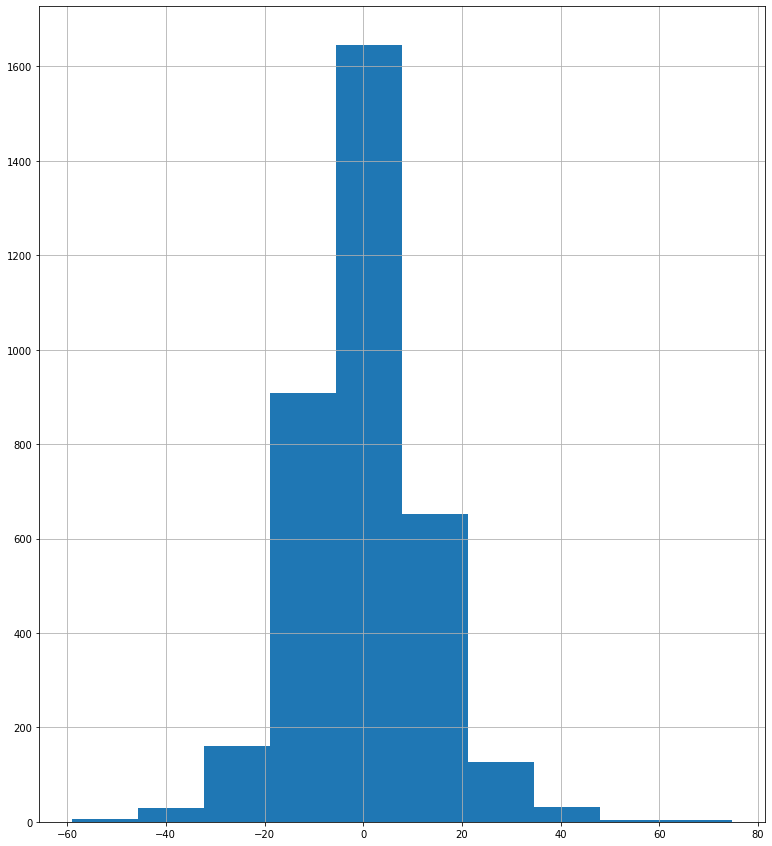

In [26]:
pd.Series(data=[gd_sr.best_estimator_.predict(X_test)-Y_test]).hist()

In [28]:
holdout_df['yield_x'] = gd_sr.best_estimator_.predict(holdout_df.loc[:,holdout_df.columns != 'yield_x'])

In [29]:
holdout_df['adm2_code']=encoder.inverse_transform(holdout_df['adm2_code'].values.reshape(-1, 1))

# Output cleanup: Drop derived features, rename yield column

In [32]:
holdout_df.rename(columns={'yield_x':'yield'},inplace=True)

In [34]:
holdout_df=holdout_df.drop(['met_extreme_cold_sum',
       'met_extreme_hot1_sum', 'met_extreme_hot2_sum', 'met_avg_t_mean',
       'met_min_t_min', 'met_max_t_max', 'met_max_vpd_max', 'met_min_rh_min',
       'met_p_mm_mean', 'met_p_mm_min', 'met_p_mm_max', 'met_sh_mean',
       'met_sh_min', 'met_sh_max', 'met_sr_wm2_mean', 'met_sr_wm2_min',
       'met_sr_wm2_max', 'mod_evi_mean', 'mod_evi_min', 'mod_evi_max',
       'mod_lst_day_mean', 'mod_lst_day_min', 'mod_lst_day_max',
       'mod_lst_night_mean', 'mod_lst_night_min', 'mod_lst_night_max',
       'mod_ndvi_mean', 'mod_ndvi_min', 'mod_ndvi_max', 'mod_nbar_1_mean',
       'mod_nbar_1_min', 'mod_nbar_1_max', 'mod_nbar_2_mean', 'mod_nbar_2_min',
       'mod_nbar_2_max', 'mod_nbar_3_mean', 'mod_nbar_3_min', 'mod_nbar_3_max',
       'mod_nbar_4_mean', 'mod_nbar_4_min', 'mod_nbar_4_max',
       'mod_nbar_5_mean', 'mod_nbar_5_min', 'mod_nbar_5_max',
       'mod_nbar_6_mean', 'mod_nbar_6_min', 'mod_nbar_6_max',
       'mod_nbar_7_mean', 'mod_nbar_7_min', 'mod_nbar_7_max'],axis=1)

In [35]:
holdout_df.head()

,adm2_code,year,phen_gup,phen_dor,yield
0,US01031,2018,72,295,134.975739
1,US01033,2018,84,281,139.580872
2,US01049,2018,73,299,148.953613
3,US01071,2018,77,292,142.352692
4,US01077,2018,78,284,156.767395


In [36]:
holdout_df.to_csv('output_yield_2018.csv',index=False)